In [13]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from notebooks import utils
%matplotlib inline

/home/cloudera/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/cloudera/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [1]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('file:///home/cloudera/Downloads/big-data-4/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [2]:
df.count()

1587257

In [3]:
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()

158726

In [5]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,NaN,0,1587250
air_pressure,158726,916.8301614102434,3.051706930842612,905.0,929.5
air_temp,158726,61.851589153636304,11.833531933851402,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.277900797383,0.0,359.0
avg_wind_speed,158680,2.775214897907747,2.057617486168092,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45184722163567,0.0,359.0
max_wind_speed,158680,3.400557726241518,2.4187939991641487,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.4408021108445,0.0,359.0
min_wind_speed,158680,2.1346641038568754,1.7421070158448122,0.0,31.6


In [7]:
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count()

157812

In [8]:
filteredDF.filter(filteredDF.rain_duration == 0.0).count()

157237

In [9]:
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [10]:
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

In [11]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [14]:
featuresUsed = ['air_pressure','air_temp','avg_wind_direction','avg_wind_speed','max_wind_direction','max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [15]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [16]:
scaledData = scaledData.select("features", "rowID")
elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

In [17]:
clusters = range(2,31)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 115070.69288466622 
Training for cluster size 3 
......................WSSE = 102465.68261534112 
Training for cluster size 4 
......................WSSE = 94560.54289090875 
Training for cluster size 5 
......................WSSE = 87995.11031741899 
Training for cluster size 6 
......................WSSE = 85528.29372990961 
Training for cluster size 7 
......................WSSE = 81206.29494464787 
Training for cluster size 8 
......................WSSE = 78324.1614310588 
Training for cluster size 9 
......................WSSE = 75603.75642737781 
Training for cluster size 10 
......................WSSE = 73171.72869930456 
Training for cluster size 11 
......................WSSE = 71647.809358973 
Training for cluster size 12 
......................WSSE = 70055.3821946229 
Training for cluster size 13 
......................WSSE = 69614.51902040234 
Training for cluster size 14 
......................WSSE = 68073.905048995

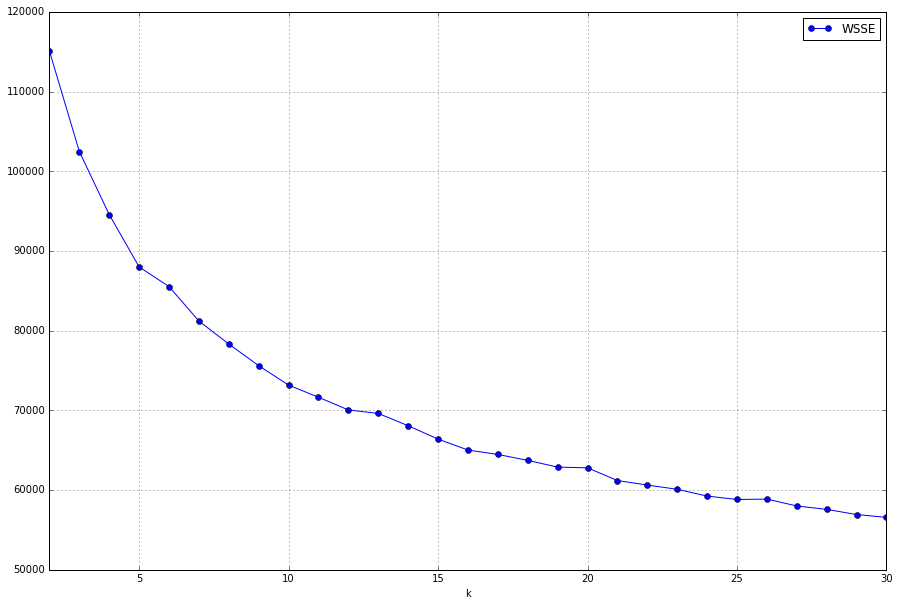

In [18]:
utils.elbow_plot(wsseList, clusters)

In [19]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [20]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)


In [21]:
centers = model.clusterCenters()
centers

[array([-0.20129176,  0.61908498,  0.40921687,  0.75082568,  0.5168438 ,
         0.68692153, -0.15899498]),
 array([ 0.42941217,  0.69361307,  0.27296021, -0.56233524,  0.45560416,
        -0.57008458, -0.73372594]),
 array([ 0.08749325, -0.81068949, -1.20052891, -0.57170074, -1.0452537 ,
        -0.58552468,  0.89683886]),
 array([ 1.37642024, -0.08734599, -1.18827277, -0.06620717, -1.05433017,
        -0.04640254, -0.97908833]),
 array([ 0.4473176 , -0.97966267,  0.72216074, -0.54023728,  0.92304617,
        -0.51879305,  1.06660605]),
 array([-1.16876036, -0.90582705,  0.44187404,  1.91984621,  0.53553923,
         1.88303613,  0.94541323]),
 array([-0.81164979,  0.3069175 ,  0.14717167, -0.55097378,  0.31612707,
        -0.56305254,  0.08652661]),
 array([ 1.18982739, -0.25351049, -1.15544529,  2.11802611, -1.05361746,
         2.23493691, -1.1342939 ]),
 array([ 0.23553891,  0.32298978,  1.88818215, -0.65265343, -1.55085482,
        -0.57753475, -0.28606688]),
 array([-0.79806308

In [22]:
P = utils.pd_centers(featuresUsed, centers)

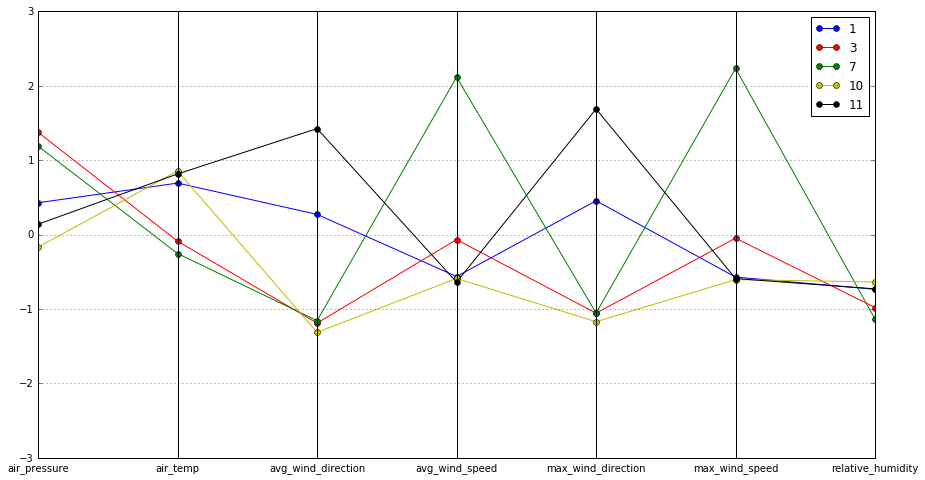

In [23]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

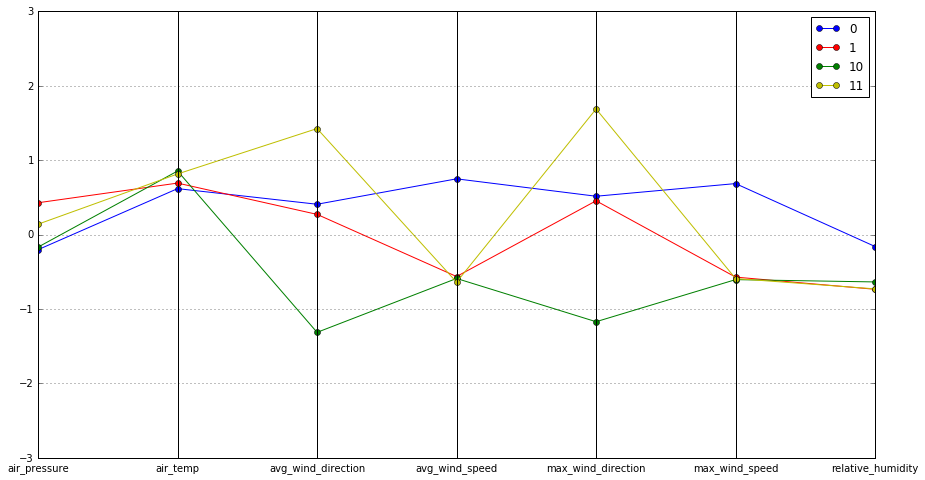

In [24]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

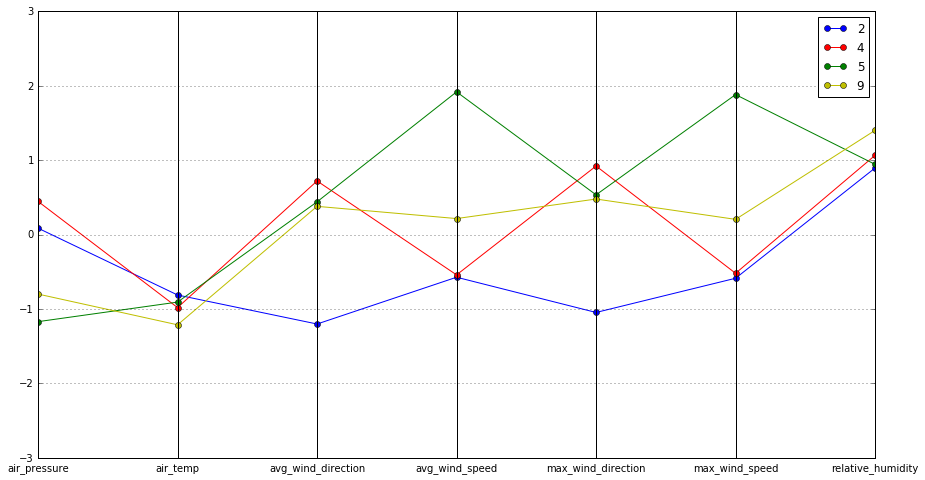

In [25]:
utils.parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp']<0.5)], P)

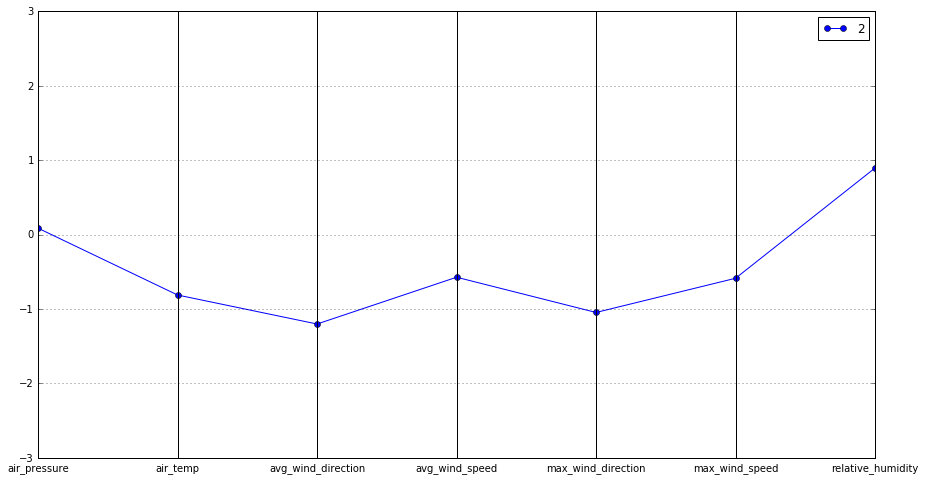

In [26]:
utils.parallel_plot(P.iloc[[2]], P)